In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm

from utils import *
from methods import *

In [3]:
res = 64
board = create_board(1.2,res=res)
model = HexagonalGCs()

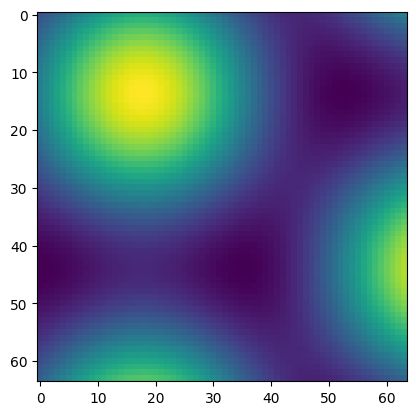

In [4]:
activity = model(board.reshape(-1,2))
plt.imshow(activity[...,0].reshape(res,res).detach().numpy())

In [5]:
class Similitude(HexagonalGCs):
    def __init__(self,**kwargs):
        super(Similitude, self).__init__(**kwargs)
    
    def loss_fn(self,r):
        J = self.jacobian(r)
        det_J = self.the_jacobian(J)
        return torch.var(det_J)

In [6]:
model = Similitude(ncells=7)

In [7]:
# Train model
loss_history = []
phases_history = [model.phases.clone().detach().numpy()]
for epoch in tqdm.trange(100):
    loss = model.train_step(board.reshape(-1,2))
    loss_history.append(loss)
    phases_history.append(model.phases.clone().detach().numpy())

100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 128.47it/s]


1.4993433952331543

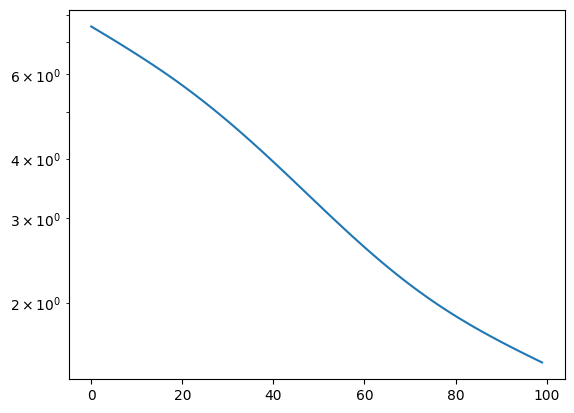

In [8]:
plt.plot(loss_history)
plt.semilogy()
loss_history[-1]

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

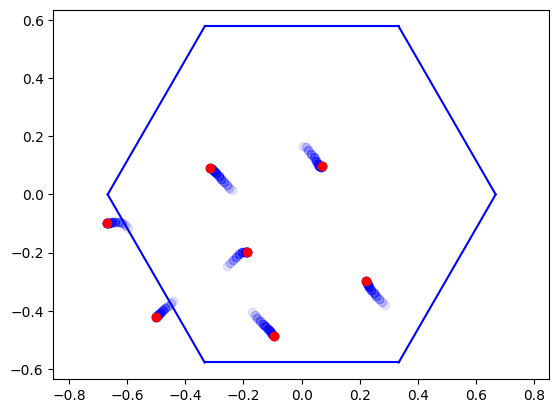

In [9]:
N = len(phases_history)
fig, ax = plt.subplots()
[ax.scatter(*phases_history[i].T, c='blue', alpha=i/N) for i in range(0,N,10)]
ax.scatter(*phases_history[-1].T, c='red')
ax.axis('equal')
model.inner_hexagon.plot(fig,ax)
#model.inner_hexagon.plot(fig,ax,center=np.mean(phases_history[-1],axis=0))

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

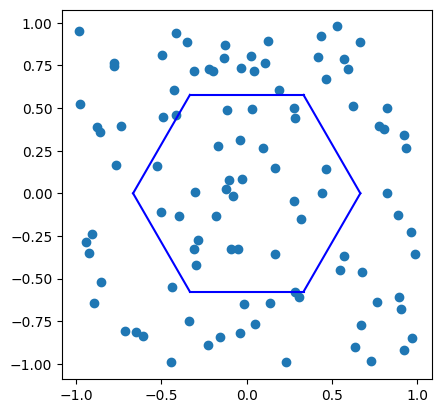

In [10]:
points = np.random.uniform(-1,1,size=(100,2))
fig, ax = plt.subplots()
ax.scatter(*points.T)
model.inner_hexagon.plot(fig,ax)

In [11]:
activity = model(torch.tensor(points,dtype=torch.float32))

In [12]:
for i in range(len(points)):
    points[i] = model.inner_hexagon.wrap(points[i])

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

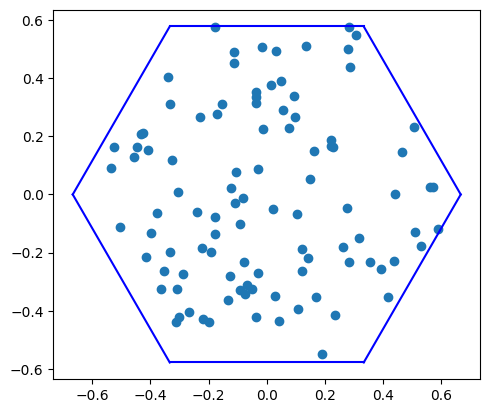

In [13]:
fig, ax = plt.subplots()
ax.scatter(*points.T)
model.inner_hexagon.plot(fig,ax)

### WHY NOT THE SAME?

In [28]:
model(torch.tensor([[0,2/3]]))

tensor([[0.0011, 0.1014, 0.3431, 0.5460, 0.4159, 0.1124, 0.9423]],
       grad_fn=<MulBackward0>)

In [31]:
model(torch.tensor([[0,-2/3]]))

tensor([[0.1103, 0.3053, 0.4496, 0.2277, 0.1117, 0.1114, 0.7538]],
       grad_fn=<MulBackward0>)

In [17]:
activity2 = model(torch.tensor(points,dtype=torch.float32))

In [18]:
activity.shape

torch.Size([100, 7])

In [19]:
torch.sum((activity - activity2)**2)

tensor(3.6093e-12, grad_fn=<SumBackward0>)

(array([37., 17.,  6., 12.,  9.,  4.,  6.,  3.,  4.,  2.]),
 array([0.00000000e+00, 1.36168856e-14, 2.72337711e-14, 4.08506575e-14,
        5.44675423e-14, 6.80844270e-14, 8.17013151e-14, 9.53181964e-14,
        1.08935085e-13, 1.22551966e-13, 1.36168854e-13], dtype=float32),
 <BarContainer object of 10 artists>)

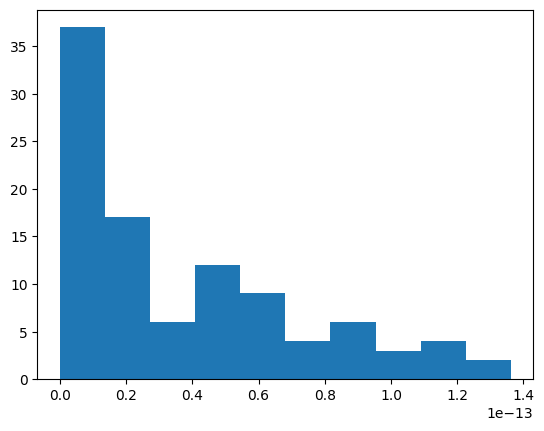

In [20]:
plt.hist(torch.sum((activity - activity2)**2,axis=-1).detach().numpy())